In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions,plot_xgb_feature_importance


In [4]:
sheet = pd.read_excel('data_input/秦皇岛动力煤.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')

sheet = sheet.rename(columns={'秦皇岛动力煤价格Q5500': '秦皇岛动力煤价格'})

last_day = sheet['秦皇岛动力煤价格'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=25, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,秦皇岛动力煤价格,北方港口动力煤库存,荷兰天然气期货价格,WTI原油期货价格,路透中国煤炭到港量/周度,动力煤日耗/25省/7DMA超季节性/3年,电厂煤炭库存/90DMA,中国10年期国债收益率Trend/F0.04,北方港口动力煤库存Trend/F0.06,动力煤日耗/25省Trend/F0.08
2025-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
sheet.columns

Index(['秦皇岛动力煤价格', '北方港口动力煤库存', '荷兰天然气期货价格', 'WTI原油期货价格', '路透中国煤炭到港量/周度',
       '动力煤日耗/25省/7DMA超季节性/3年', '电厂煤炭库存/90DMA', '中国10年期国债收益率Trend/F0.04',
       '北方港口动力煤库存Trend/F0.06', '动力煤日耗/25省Trend/F0.08'],
      dtype='object')

In [6]:
################################# 处理缺失值 #################################
fill_methods = {
'北方港口动力煤库存':'interpolate', 
'荷兰天然气期货价格':'interpolate', 
'WTI原油期货价格':'interpolate', 
'路透中国煤炭到港量/周度':'interpolate',
'动力煤日耗/25省/7DMA超季节性/3年':'interpolate', 
'电厂煤炭库存/90DMA':'interpolate',
'中国10年期国债收益率Trend/F0.04':'interpolate',
'北方港口动力煤库存Trend/F0.06':'interpolate',
'动力煤日耗/25省Trend/F0.08':'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, '北方港口动力煤库存'] = sheet.loc[:last_day, '北方港口动力煤库存'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['北方港口动力煤库存_提前28天'] = sheet['北方港口动力煤库存'].shift(28)
sheet['荷兰天然气期货价格_提前60天'] = sheet['荷兰天然气期货价格'].shift(84)
sheet['WTI原油期货价格_提前60天'] = sheet['WTI原油期货价格'].shift(60)
sheet['路透中国煤炭到港量/周度_提前40天'] = sheet['路透中国煤炭到港量/周度'].shift(40)
sheet['动力煤日耗/25省/7DMA超季节性/3年_提前28天'] = sheet['动力煤日耗/25省/7DMA超季节性/3年'].shift(28)
sheet['电厂煤炭库存/90DMA_提前224天'] = sheet['电厂煤炭库存/90DMA'].shift(160)                 
sheet['中国10年期国债收益率Trend/F0.04_提前20天'] = sheet['中国10年期国债收益率Trend/F0.04'].shift(20)
sheet['北方港口动力煤库存Trend/F0.06_提前20天'] = sheet['北方港口动力煤库存Trend/F0.06'].shift(20)
sheet['动力煤日耗/25省Trend/F0.08_提前20天'] = sheet['动力煤日耗/25省Trend/F0.08'].shift(20)

sheet['北方港口动力煤库存_提前28天_逆序'] = reverse_column(sheet, '北方港口动力煤库存_提前28天')
sheet['路透中国煤炭到港量/周度_提前40天_逆序'] = reverse_column(sheet, '路透中国煤炭到港量/周度_提前40天')
sheet['电厂煤炭库存/90DMA_提前224天_逆序'] = reverse_column(sheet, '电厂煤炭库存/90DMA_提前224天')
sheet['北方港口动力煤库存Trend/F0.06_提前20天_逆序'] = reverse_column(sheet, '北方港口动力煤库存Trend/F0.06_提前20天')
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-09-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['秦皇岛动力煤价格'].notna())
]

################################# 数据 读取-处理 结束 #################################

In [7]:
'''
# 对所有因子进行3天移动平均平滑处理
smooth_cols = [
    '北方港口动力煤库存_提前28天_逆序',
    '荷兰天然气期货价格_提前60天', 
    'WTI原油期货价格_提前60天',
    '路透中国煤炭到港量/周度_提前40天_逆序',
    '动力煤日耗/25省/7DMA超季节性/3年_提前28天',
    '电厂煤炭库存/90DMA_提前224天_逆序'
]

for col in smooth_cols:
    sheet_daily[col] = sheet_daily[col].rolling(window=30, min_periods=1).mean()
'''

"\n# 对所有因子进行3天移动平均平滑处理\nsmooth_cols = [\n    '北方港口动力煤库存_提前28天_逆序',\n    '荷兰天然气期货价格_提前60天', \n    'WTI原油期货价格_提前60天',\n    '路透中国煤炭到港量/周度_提前40天_逆序',\n    '动力煤日耗/25省/7DMA超季节性/3年_提前28天',\n    '电厂煤炭库存/90DMA_提前224天_逆序'\n]\n\nfor col in smooth_cols:\n    sheet_daily[col] = sheet_daily[col].rolling(window=30, min_periods=1).mean()\n"

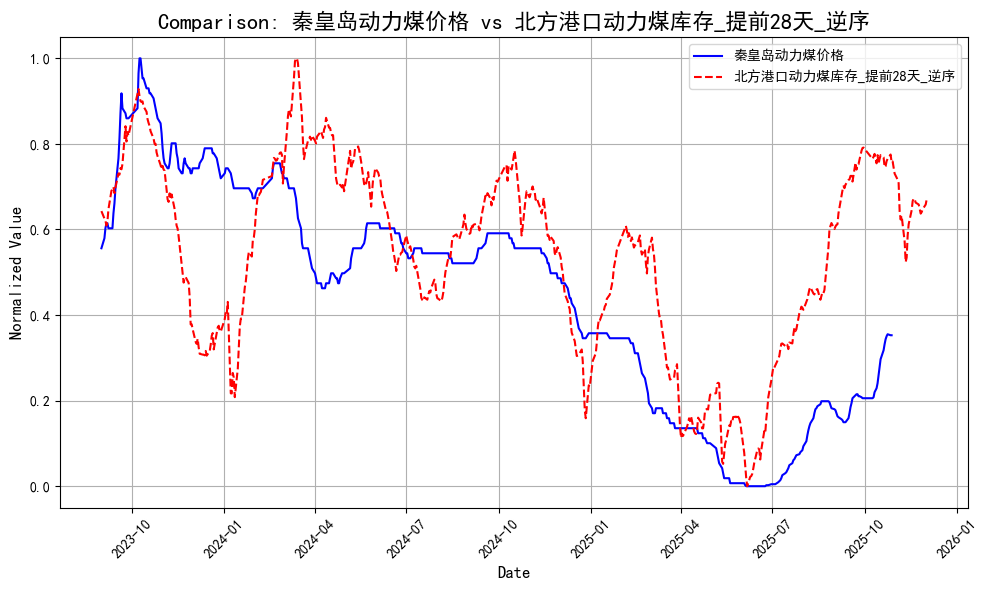

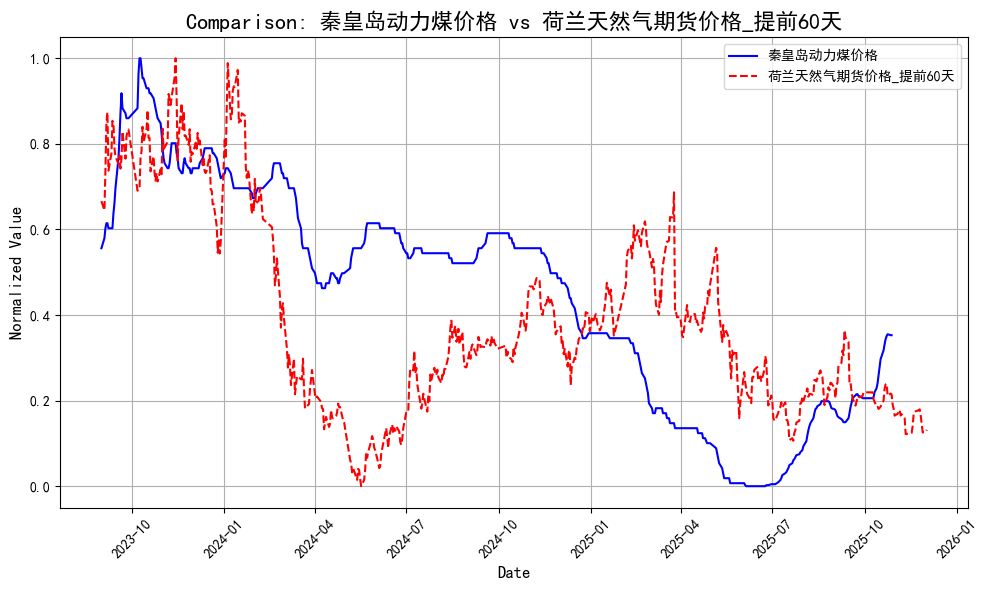

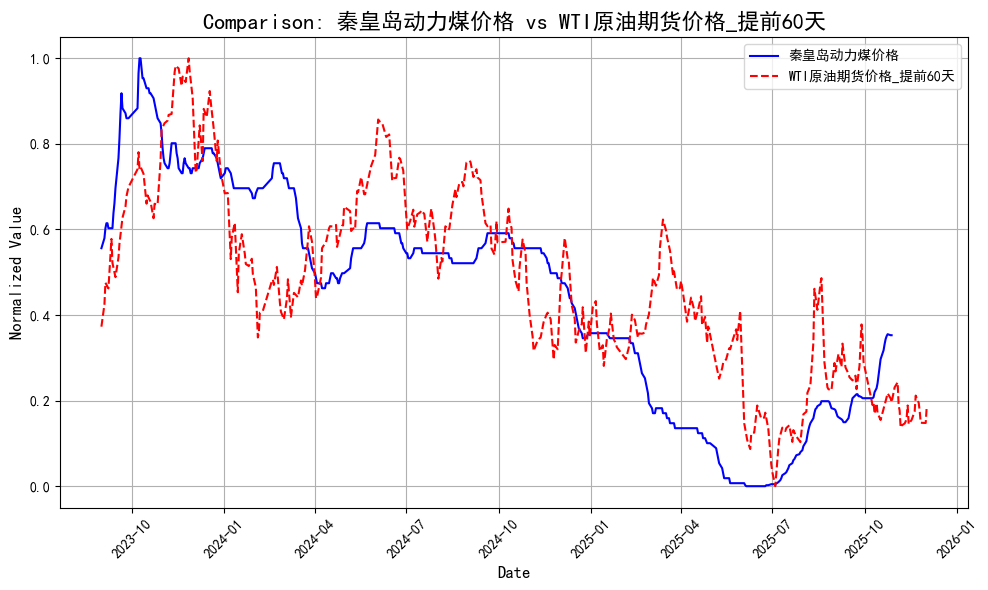

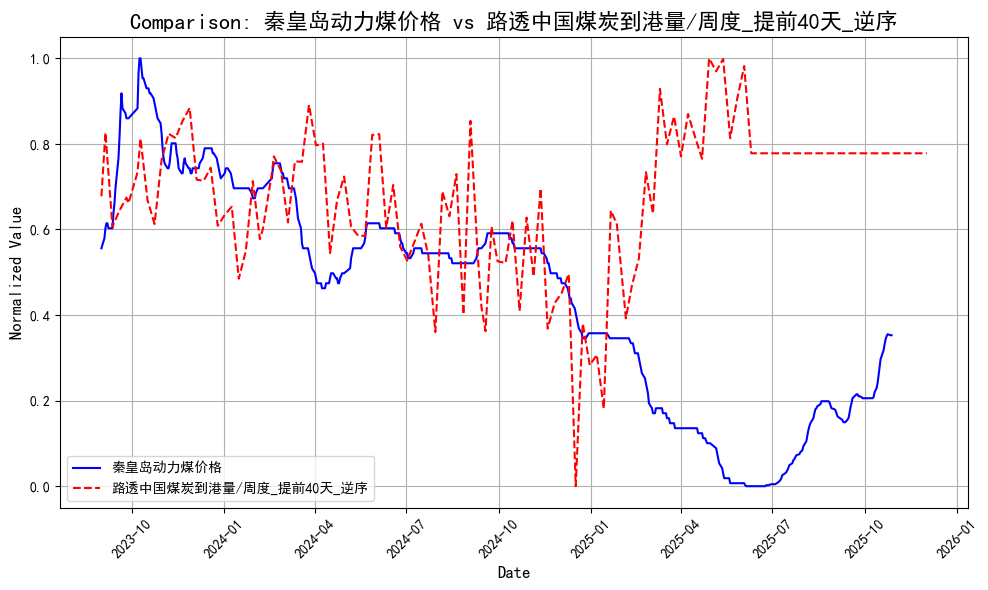

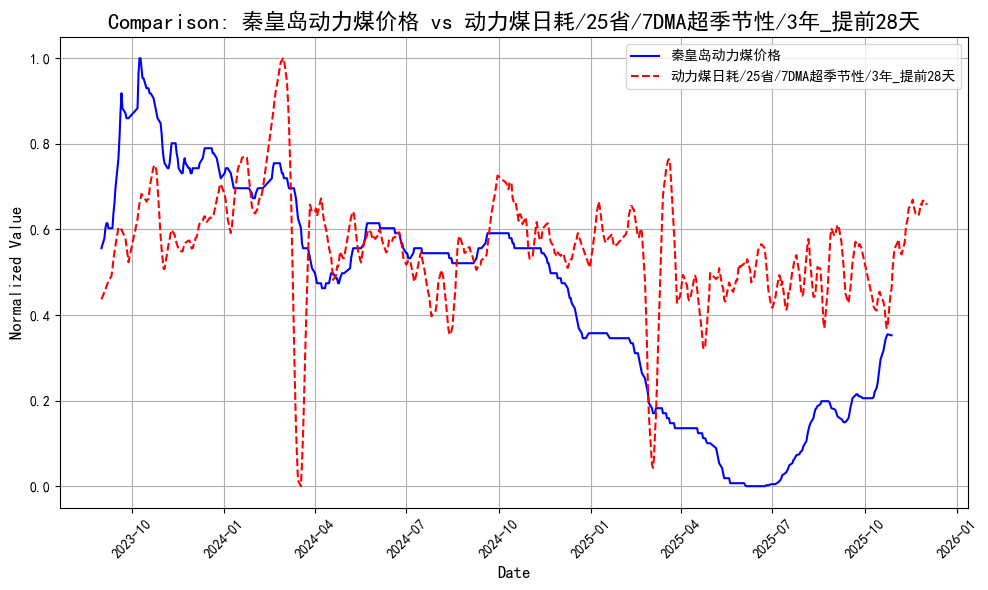

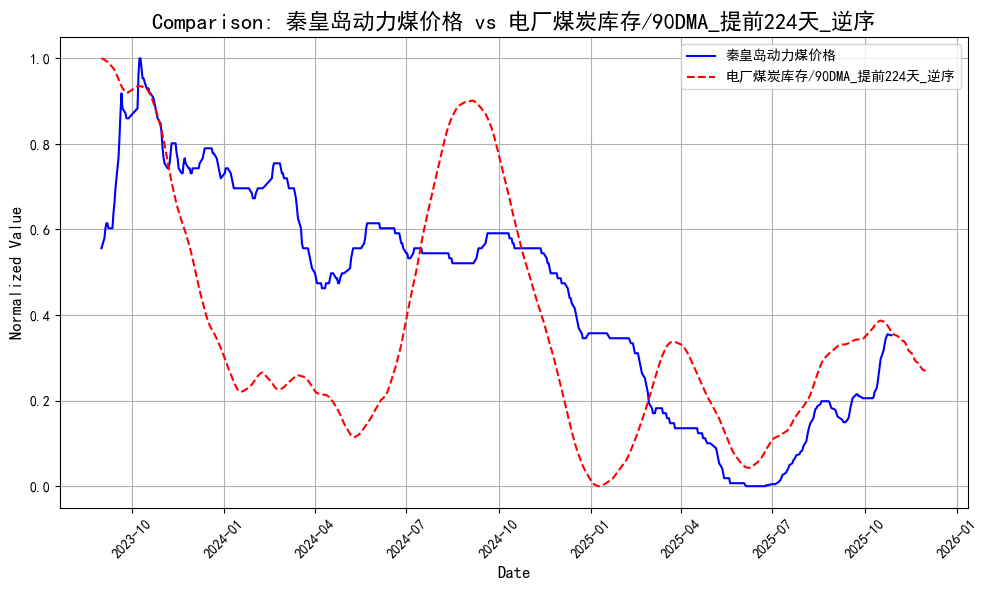

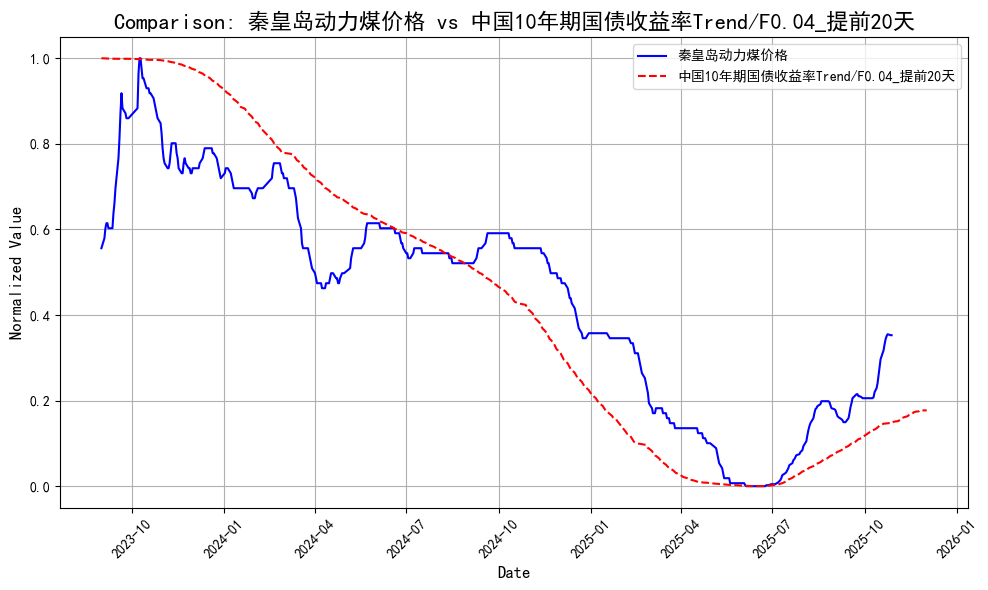

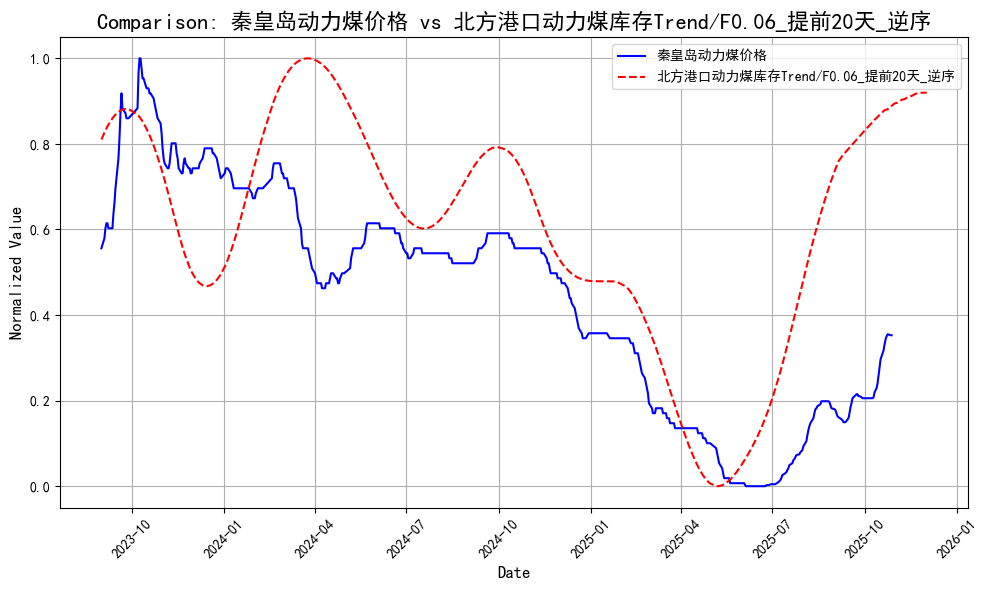

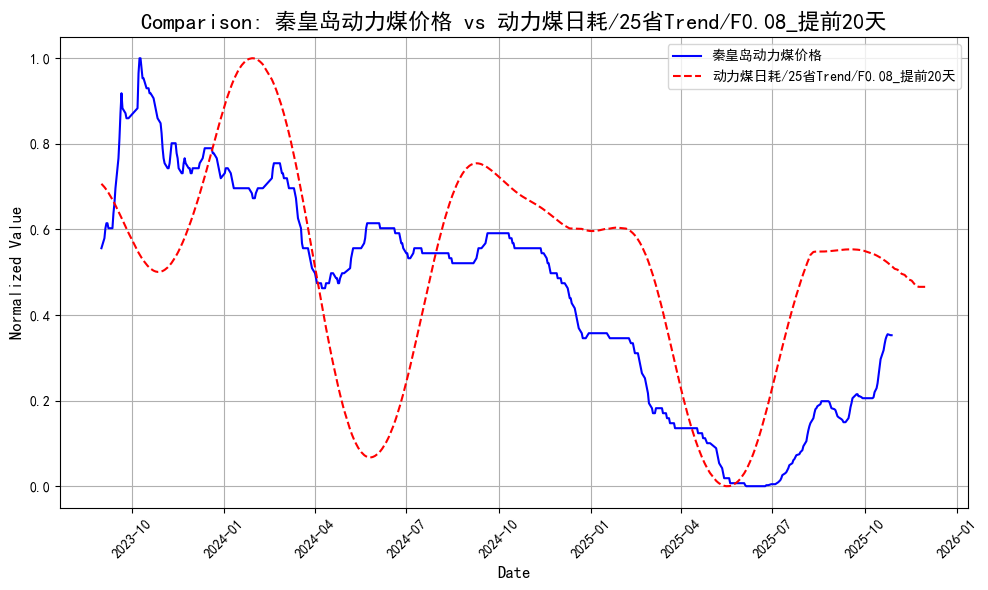

In [8]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='秦皇岛动力煤价格', 
    compare_cols=[
        '北方港口动力煤库存_提前28天_逆序',
        '荷兰天然气期货价格_提前60天',
        'WTI原油期货价格_提前60天',
        '路透中国煤炭到港量/周度_提前40天_逆序',
        '动力煤日耗/25省/7DMA超季节性/3年_提前28天',
        '电厂煤炭库存/90DMA_提前224天_逆序',
        '中国10年期国债收益率Trend/F0.04_提前20天',
        '北方港口动力煤库存Trend/F0.06_提前20天_逆序',
        '动力煤日耗/25省Trend/F0.08_提前20天'
        ]
)

In [9]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 20
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '北方港口动力煤库存_提前28天_逆序',
        '荷兰天然气期货价格_提前60天',
        'WTI原油期货价格_提前60天',
        #'动力煤日耗/25省/7DMA超季节性/3年_提前28天',
        '电厂煤炭库存/90DMA_提前224天_逆序',
        '中国10年期国债收益率Trend/F0.04_提前20天',
        '北方港口动力煤库存Trend/F0.06_提前20天_逆序',
        '动力煤日耗/25省Trend/F0.08_提前20天'
]

predict_column = '秦皇岛动力煤价格'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.5, 
    'max_depth': 7, 
    'min_child_weight': 3, 
    'subsample': 0.9, 
    'colsample_bytree': 0.9, 
    'gamma': 0.5, 
    'reg_alpha': 2, 
    'reg_lambda': 2,
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
#    'max_delta_step': 5,
    'tree_method': 'auto',
    'booster': 'gblinear'  # 使用线性提升器
}
 

num_boost_round = 100
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:69.01797	train-rmse:57.56390


[99]	eval-rmse:61.51796	train-rmse:53.39740


训练集 MSE (DMatrix): 2881.3939, 训练集 R² (DMatrix): 0.767
测试集 MSE (DMatrix): 3784.4599, 测试集 R² (DMatrix): -4.726


C:\Users\Hz\miniconda3\envs\myenv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [15:40:20] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "tree_method" } are not used.

  self.starting_round = model.num_boosted_rounds()


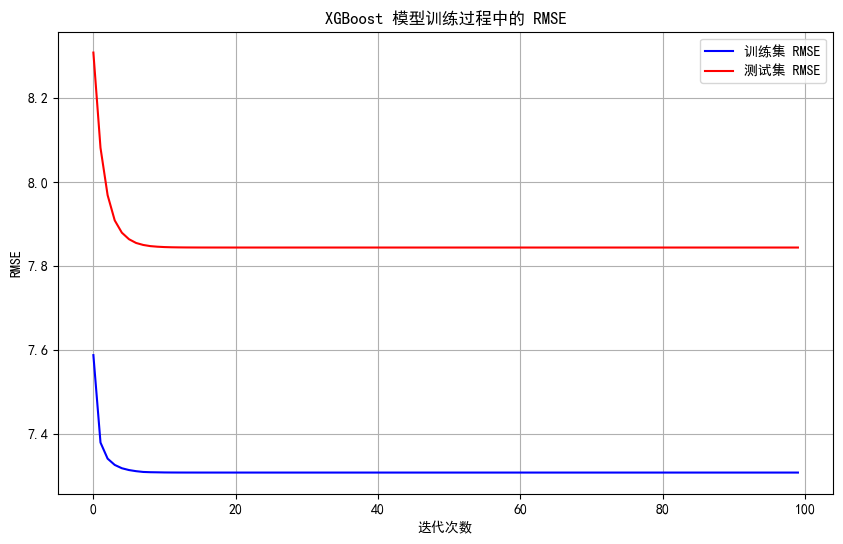

In [10]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:59.10903


[99]	train-rmse:53.81895


全部数据 MSE: 2927.7994, 全部数据 R²: 0.7591


C:\Users\Hz\miniconda3\envs\myenv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [15:40:20] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "tree_method" } are not used.

  self.starting_round = model.num_boosted_rounds()


Gap between last actual value and first prediction: -13.90069580078125


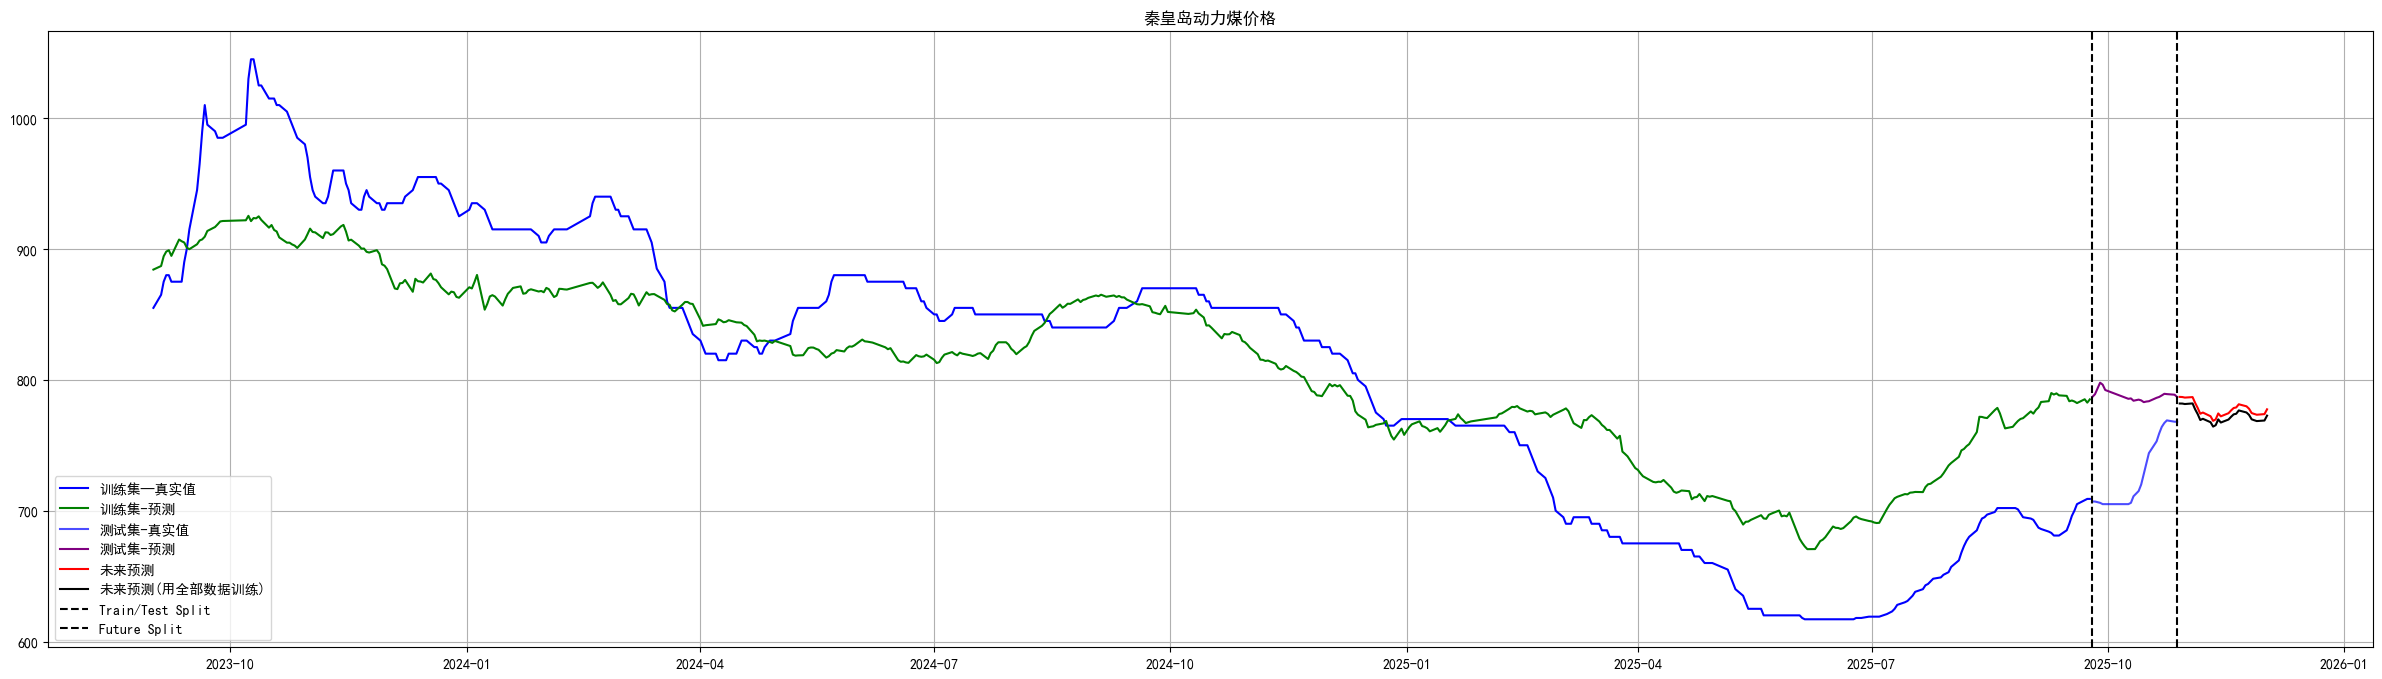

In [12]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('秦皇岛动力煤价格')
plt.legend()
plt.grid(True)
plt.show()

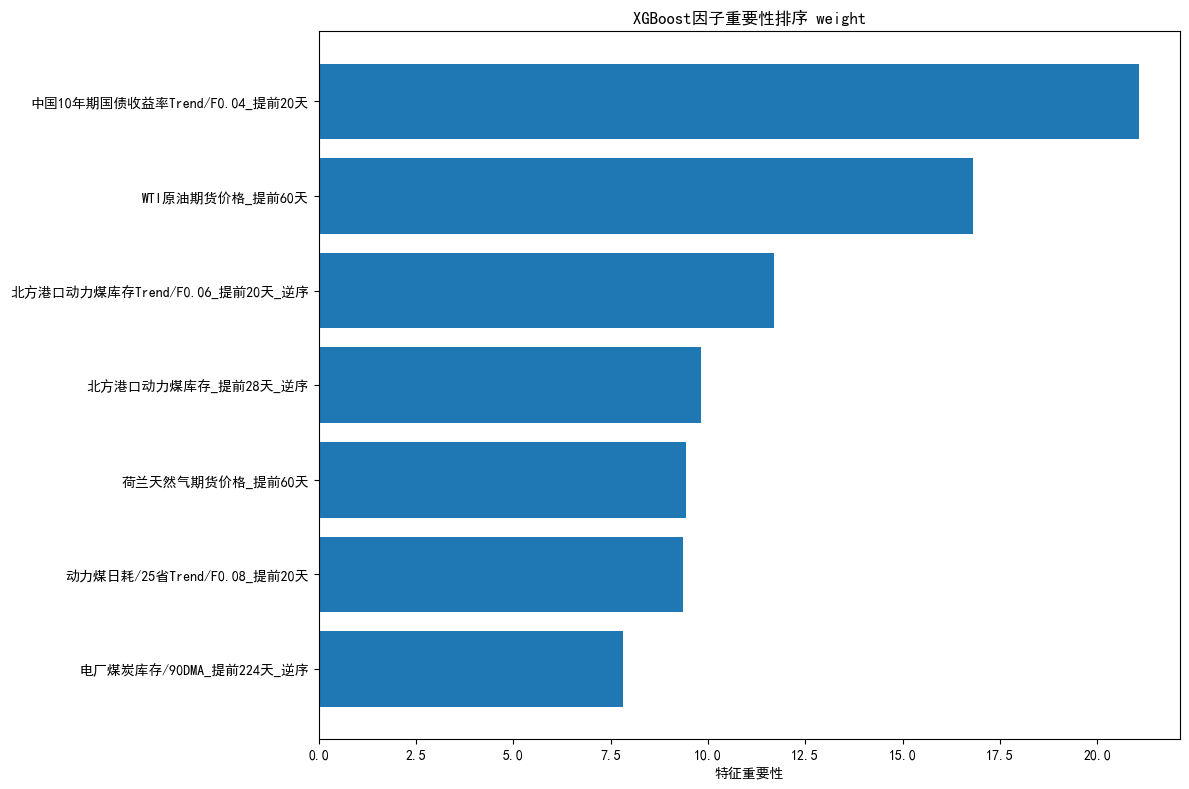

In [13]:
# 创建特征重要性排序的DataFrame
plt.figure(figsize=(12, 8))
importance_type = 'weight'  # 使用weight类型
feature_importance = model_all.get_score(importance_type=importance_type)

importance_df = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
})

# 将特征名称从f0、f1等映射到实际的列名
feature_names = dict(zip([f'f{i}' for i in range(len(X_train.columns))], X_train.columns))
importance_df['feature_name'] = importance_df['feature'].map(feature_names)

# 按重要性降序排序
importance_df_sorted = importance_df.sort_values('importance', ascending=True)

# 绘制水平条形图
plt.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])
plt.yticks(range(len(importance_df_sorted)), importance_df_sorted['feature_name'].tolist(), fontsize=10)  # 转换为list
plt.xlabel('特征重要性')
plt.title('XGBoost因子重要性排序 weight')
plt.tight_layout()
plt.show()


In [14]:

#绘制因子重要性
#plot_xgb_feature_importance(model_all, X_train)

---

In [15]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/秦皇岛动力煤价格_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
559,2025/12/02,NaN,772.636658
558,2025/12/01,NaN,768.914185
557,2025/11/28,NaN,768.483826
556,2025/11/27,NaN,769.131470
555,2025/11/26,NaN,769.848145
...,...,...,...
4,2023/09/07,880.0,NaN
3,2023/09/06,880.0,NaN
2,2023/09/05,875.0,NaN
1,2023/09/04,865.0,NaN


In [16]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/秦皇岛动力煤价格_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly

,Date,真实值,预测值
27,2025/12/31,NaN,770.775391
26,2025/11/30,NaN,771.425903
25,2025/10/31,740.866667,785.280273
24,2025/09/30,695.304348,785.460876
23,2025/08/31,689.666667,762.729980
22,2025/07/31,634.260870,712.160034
21,2025/06/30,617.450000,683.617371
20,2025/05/31,628.157895,696.879028
19,2025/04/30,670.227273,716.835022
18,2025/03/31,686.428571,762.454102


In [17]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.动力煤_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "秦皇岛动力煤"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [18]:
from Lcel import update_excel_data
file_path = "eta/1.动力煤_数据上传.xlsx"
sheet_name = "详情页"
identifier = "秦皇岛动力煤"
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列
已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
